In [1]:
import pandas as pd

In [19]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# set up plotly defaults
pio.renderers.default = "plotly_mimetype+svg"
pio.templates["book"] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350,
        height=250,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        title=dict(x=0.5, xanchor="center"),
    )
)
pio.templates.default = "simple_white+book"

def margin(fig, **kwargs):
    """Set margins for a plotly figure"""
    return fig.update_layout(margin=kwargs)

# Transforming

Data scientists transform dataframe columns when they need to change each value
in a feature in the same way. For example, if a feature contains heights of
people in feet, a data scientist might want to transform the heights to
centimeters. In this section, we'll introduce *apply*, an operation that
transforms columns of data using a user-defined function.

In [20]:
baby = pd.read_csv('data/babynames.csv')
baby

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
3,Elijah,M,13034,2020
4,William,M,12541,2020
...,...,...,...,...
2020717,Ula,F,5,1880
2020718,Vannie,F,5,1880
2020719,Verona,F,5,1880
2020720,Vertie,F,5,1880


In the baby names New York Times article {cite}`williamsLilith2021`, Pamela
mentions that names starting with the letter "L" and "K" became popular
after 2000. On the other hand, names starting with the letter "J" peaked in
popularity in the 1970s and 1980s and have dropped off in popularity since. We
can verify these claims using the `baby` dataset.

We approach this problem using the following steps:

1. Transform the `Name` column into a new column that contains the first
   letters of each value in `Name`.
2. Group the dataframe by the first letter and year.
3. Aggregate the name counts by summing.

To complete the first step, we'll *apply* a function to the `Name` column. 

## Apply 

`pd.Series` objects contain an `.apply()` method that takes in a function and
applies it to each value in the series. For instance, to find the lengths of
each name, we apply the `len` function.

In [21]:
names = baby['Name']
names.apply(len)

0          4
1          4
2          6
3          6
4          7
          ..
2020717    3
2020718    6
2020719    6
2020720    6
2020721    5
Name: Name, Length: 2020722, dtype: int64

To extract the first letter of each name, define a custom function and pass it
into `.apply()`.

In [22]:
# The argument to the function is an individual value in the series. 
def first_letter(string):
    return string[0]

names.apply(first_letter)

0          L
1          N
2          O
3          E
4          W
          ..
2020717    U
2020718    V
2020719    V
2020720    V
2020721    W
Name: Name, Length: 2020722, dtype: object

Using `.apply()` is similar to using a `for` loop. The code above is roughly
equivalent to writing:

```python
result = []
for name in names:
    result.append(first_letter(name))
```

Now, we can assign the first letters to a new column in the dataframe:

In [23]:
letters = baby.assign(Firsts=names.apply(first_letter))
letters

,Name,Sex,Count,Year,Firsts
0,Liam,M,19659,2020,L
1,Noah,M,18252,2020,N
2,Oliver,M,14147,2020,O
3,Elijah,M,13034,2020,E
4,William,M,12541,2020,W
...,...,...,...,...,...
2020717,Ula,F,5,1880,U
2020718,Vannie,F,5,1880,V
2020719,Verona,F,5,1880,V
2020720,Vertie,F,5,1880,V


:::{note}

To create a new column in a dataframe, you might also encounter this syntax:

```python
baby['Firsts'] = names.apply(first_letter)
```

This mutates the `baby` table by adding a new column called `Firsts`. In the
code above, we use `.assign()` which doesn't mutate the `baby` table itself; it
creates a new dataframe instead. Mutating dataframes isn't wrong but can be a
common source of bugs. Because of this, we'll mostly use `.assign()` in this
book. 

:::

## Example: Popularity of "L" Names

Now, we can use the `letters` dataframe to see the popularity of first letters
over time.

In [24]:
letter_counts = (letters
               .groupby(['Firsts', 'Year'])
               ['Count']
               .sum()
               .reset_index()
                       )
letter_counts

,Firsts,Year,Count
0,A,1880,16740
1,A,1881,16257
2,A,1882,18790
3,A,1883,18831
4,A,1884,20898
...,...,...,...
3636,Z,2016,54679
3637,Z,2017,54495
3638,Z,2018,55996
3639,Z,2019,55293


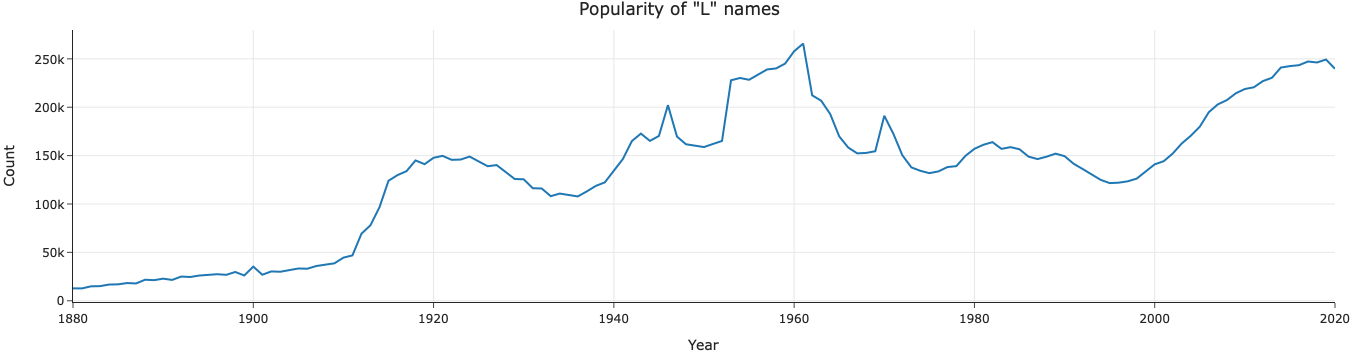

In [26]:
fig = px.line(letter_counts.loc[letter_counts['Firsts']=='L'],
              x = 'Year', y = 'Count', title = 'Popularity of "L" names',
              width=350, height=250)
margin(fig,t=30)

The plot shows that "L" names were popular in the 1960s, dipped in the decades
after, but have indeed resurged in popularity after 2000. 

What about "J" names?

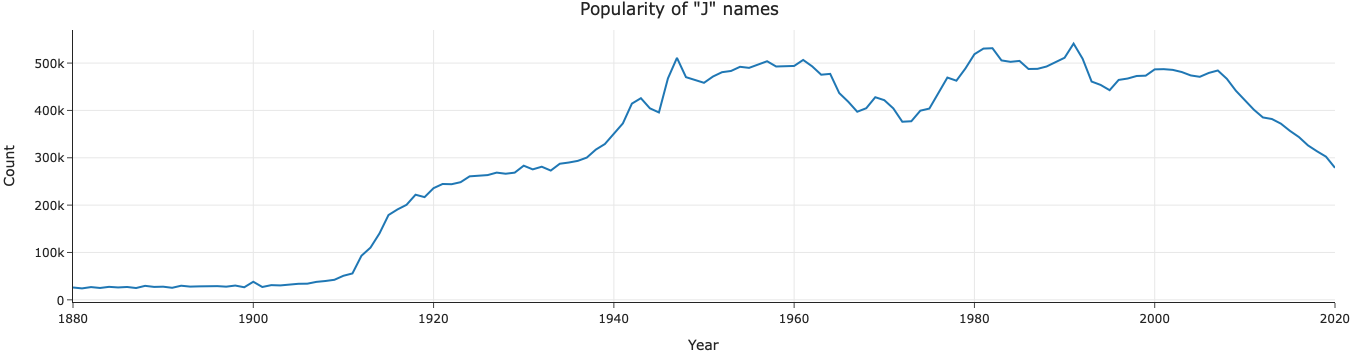

In [27]:
fig = px.line(letter_counts.loc[letter_counts['Firsts']=='J'],
              x='Year', y='Count', title='Popularity of "J" names',
              width=350,height=250)
margin(fig,t=30)

The NYT article says that "J" names were popular in the 1970s and 80s. The plot
agrees, and also shows that they have become less popular after 2000.

## The Price of Apply

The power of `.apply()` is its flexibility---you can call it with any function
that takes in a single data value and outputs a single data value.

Its flexibility has a price, though. Using `.apply()` can be slow, since
`pandas` can't optimize arbitrary functions. For example, using `.apply()` for
numeric calculations is much slower than using vectorized operations directly
on `pd.Series` objects:

In [28]:
%%timeit

# Calculate the decade using vectorized operators
baby['Year'] // 10 * 10

7.45 ms ± 56 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%%timeit

def decade(yr):
    return yr // 10 * 10

# Calculate the decade using apply
baby['Year'].apply(decade)

600 ms ± 3.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The version using `.apply()` is 30 times slower! For numeric
operations in particular, we recommend operating on `pd.Series` objects
directly.

## Takeaways

To transform values in a dataframe, we commonly use the `.apply()` and
`.assign()` functions.
In the next section, we'll compare dataframes with other ways to represent and
manipulate data tables.